# ASI Challenge Exercise
### Naive Bayes Classification and Baysian Linear Regression on the MNIST and CIFAR10 datasets
<i>Claudio SCALZO</i>

In [1]:
# LIBRARIES IMPORT
import numpy as np
import pandas as pd
import math as math
from time import time
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, probplot, multivariate_normal

# 1. Datasets loading

### 1.1 Fashion MNIST

In [2]:
# DIRECTORY DEFINITION
mnistPath = "./datasets/Fashion-MNIST/"

# FILEPATHS DEFINITION
mnistTrainFile = mnistPath + "fashion-mnist_train.csv"
mnistTestFile = mnistPath + "fashion-mnist_test.csv"

# LOAD THE MNIST AND CIFAR TRAINSET AND DATASET
mnistTrain = pd.read_csv(mnistTrainFile)
mnistTest = pd.read_csv(mnistTestFile)

### 1.2 CIFAR-10

In [3]:
# FUNCTION TO LOAD A SINGLE TRAINFILE
def loadImages(filename):
    
    # Load binary file
    file = open(filename, "rb")
    
    # Unpickle
    data = pickle.load(file, encoding="bytes")
    
    # Get raw images and raw classes
    rawImages = data[b'data']
    rawClasses = data[b'labels']

    # Make numpy arrays
    imgs = np.array(rawImages, dtype=float) / 255.0
    clss = np.array(rawClasses)
    
    # Reshape the images
    imgs = imgs.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])
    
    return imgs, clss

In [4]:
# DIRECTORY AND CONSTANTS DEFINITION
cifarPath = "./datasets/CIFAR-10/"
numTrainFiles = 5
numImagesPerFile = 10000
numImages = numImagesPerFile * numTrainFiles
imageWidth = 32
imageHeight = 32
imageChannels = 3

# ALLOCATIONS
images = np.zeros(shape=[numImages, imageHeight, imageWidth, imageChannels], dtype=float)
classes = np.zeros(shape=[numImages], dtype=int)

# LOAD ALL THE TRAINFILES
begin = 0
for i in range(numTrainFiles):
    
    # Load the images and classes for the "i"th trainfile
    images_batch, cls_batch = loadImages(filename = cifarPath + "data_batch_" + str(i + 1))

    # Images in this batch
    num_images = len(images_batch)

    # Append to the general arrays
    end = begin + num_images
    images[begin:end, :] = images_batch
    classes[begin:end] = cls_batch
    begin = end

In [5]:
# ACTUAL DIMENSIONS MEANING: [ImageNumber, HeightPixel, WidthPixel, Channel]
# NEW DIMENSIONS MEANING: [ImageNumber, Pixel]

# ALLOCATE ARRAYS
imagesNew = np.zeros(shape=[numImages, imageHeight * imageWidth], dtype=float)
imageTmp = np.zeros(shape=[imageHeight, imageWidth], dtype=float)

# FOR EACH IMAGE
for i in range(numImages):
    
    # CREATE A TEMPORARY BLACK & WHITE PICTURE
    imageTmp[:,:] = 0.21 * images[i,:,:,0] + 0.72 * images[i,:,:,1] + 0.07 * images[i,:,:,2]
    
    # RAVEL THE PICTURE IN ONE ROW
    imagesNew[i] = np.ravel(imageTmp)

In [21]:
# ADD THE LABEL COLUMN
images = np.concatenate((np.asmatrix(classes).T, imagesNew), axis=1)

# CREATE THE DATAFRAME
attributes = [("pixel" + str(i)) for i in range(imageHeight*imageWidth)]
cifarTrain = pd.DataFrame(images, columns=["label"] + attributes)
cifarTrain["label"] = cifarTrain["label"].astype(int)
cifarTrain.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023
0,6,0.240941,0.177647,0.188510,0.220000,0.301098,0.372235,0.437176,0.451961,0.477490,...,0.362549,0.370863,0.395961,0.360667,0.277569,0.320706,0.563843,0.735843,0.480588,0.380824
1,9,0.677922,0.527922,0.406196,0.396353,0.510980,0.645765,0.735765,0.768863,0.600235,...,0.088745,0.180588,0.255098,0.355961,0.448078,0.505451,0.519686,0.531451,0.535098,0.532824
2,9,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.294353,0.313961,0.302196,0.259059,0.247294,0.270824,0.303569,0.327020,0.327843,0.331765
3,4,0.096392,0.131686,0.135608,0.145373,0.153216,0.143451,0.146549,0.087176,0.101059,...,0.319020,0.251647,0.315490,0.264118,0.296667,0.294118,0.226549,0.184863,0.220157,0.255451
4,1,0.702588,0.694745,0.723843,0.753569,0.762314,0.756745,0.760863,0.754863,0.753333,...,0.344902,0.333216,0.322275,0.309686,0.309608,0.295569,0.291647,0.307333,0.291647,0.299490
5,1,0.446667,0.406549,0.420863,0.510431,0.527961,0.609843,0.441804,0.204275,0.169961,...,0.127765,0.137176,0.150863,0.172588,0.204275,0.230745,0.251725,0.273255,0.291137,0.316039
6,2,0.739765,0.498510,0.542784,0.583922,0.591961,0.634275,0.700235,0.750157,0.809804,...,0.729373,0.626314,0.519882,0.563922,0.551451,0.521176,0.536667,0.463725,0.457608,0.592549
7,7,0.132588,0.132784,0.164314,0.305176,0.308824,0.176510,0.170314,0.226941,0.282196,...,0.487255,0.462078,0.555725,0.573137,0.536745,0.609608,0.620824,0.521333,0.513765,0.504824
8,8,0.696745,0.687804,0.679137,0.683255,0.694392,0.705333,0.695020,0.664902,0.673020,...,0.812902,0.793373,0.766902,0.685451,0.405098,0.278314,0.309490,0.328275,0.329373,0.329647
9,3,0.487725,0.400745,0.360902,0.386980,0.393176,0.533255,0.669686,0.666588,0.557333,...,0.418824,0.422196,0.429216,0.437333,0.443176,0.451569,0.459412,0.470627,0.468353,0.469725


# Descriptive statistics

### 1.1 Data description

<div class='alert alert-info'>
The first step is to investigate data. It is a fundamental section, where we will learn about our data. Initially we show and plot really simple statistics: they are not really interesting but they are useful to introduce us, to understand what we are dealing with.
</div>

In [3]:
# PRINT TO DESCRIBE THE TRAIN
print("Number of rows:", mnistTrain.shape[0])
print("Attributes:", mnistTrain.drop(columns=['label']).shape[1], "(without considering the label)")
display(mnistTrain.head(10))

Number of rows: 60000
Attributes: 784 (without considering the label)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


<div class='alert alert-success'>
The number of rows is <b>60000</b>, while the number of columns is <b>785</b> (784 attributes + 1 label). But what does they mean?<br>
<br>
<list>
    <li>Each <b>row</b> represents a picture.</li>
    <li>Each <b>column</b> represents a pixel.</li>
    <li>So, the <b>value</b> of a row <i>"r"</i> in a given column <i>"c"</i> represents the brightness (from 0 to 255) of a given pixel <i>"c"</i> in a given picture <i>"r"</i>.</li>
</list>
<br>
If training on a big (where big refers to the number of pictures) dataset represent an advantage, a big dimensionality like this (784 attributes) can represent an issue for the predictive model, generally known as "curse of dimensionality" (<a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">source</a>).
</div>

In [4]:
# PRINT TO DESCRIBE THE TEST
print("Number of rows:", mnistTest.shape[0])
print("Attributes:", mnistTest.drop(columns=['label']).shape[1], "(without considering the label)")
display(mnistTest.head(10))

Number of rows: 10000
Attributes: 784 (without considering the label)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,...,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,...,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,57,70,28,0,2,0,0,0,0,0


### 1.2 Data distribution analysis

<div class='alert alert-info'>
Now is time to analyze the distribution of our data: let's do it.
</div>

In [5]:
# TAKE DISTRIBUTION
distribution = mnistTrain["label"].value_counts()

# TAKE NUMBERS AND FREQUENCIES
numbers = np.array(distribution.index)
frequencies = np.array(distribution.values)

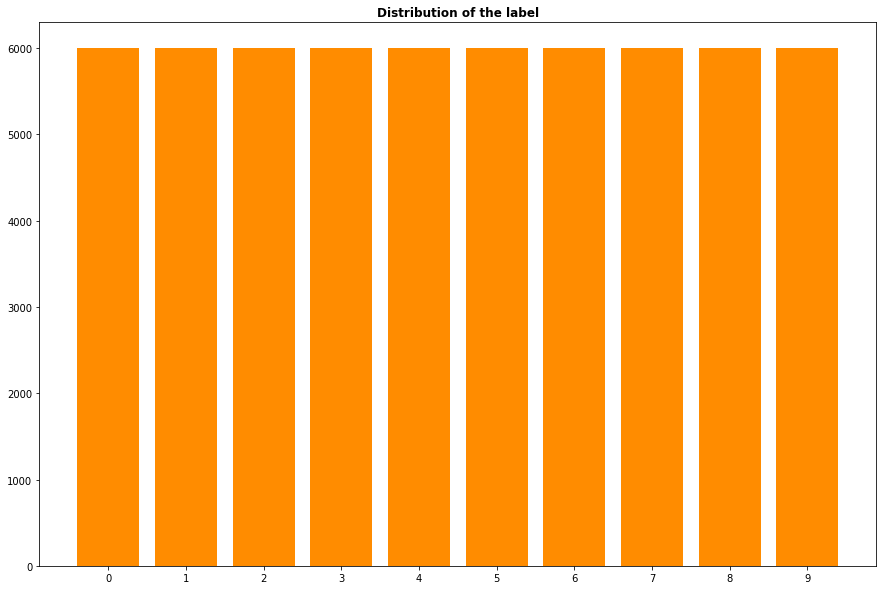

In [6]:
# PLOT THE DISTRIBUTION OF THE TARGET VARIABLE
plt.figure(figsize=(15,10))
plt.bar(numbers, frequencies, align="center", color="darkorange")
plt.xticks([i for i in range(np.min(numbers),np.max(numbers)+1)])
plt.title("Distribution of the label", weight="semibold");

<div class='alert alert-success'>
The distribution is uniform! That can be a problem for our Naive Bayes implementation, expecting a Gaussian distribution.
</div>

# 1. Naive Bayes Classifier

<div class='alert alert-info'>
Naive Bayes Classifier explanation here...
</div>

In [24]:
class NBC:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # MEANS AND VARIANCES FOR THE LIKELIHOOD: P(X|C)
    def _computeMeansCov(self):
        
        # Compute means and variances
        # -> For example:
        #    <means> |  attr0 | attr1 | ...    #  <vars> |  attr0 | attr1 | ...
        #    --------------------------        # --------------------------    
        #    class0  |   12   |   3   | ...    # class0  |   0.2  |  0.03 | ...
        #    class1  |   8    |   0   | ...    # class1  |  0.07  |  0.1  | ...
        #      ...   |  ...   |  ...  | ...    #   ...   |  ...   |  ...  | ...
        self.means = self.train.groupby("label").mean()
        self.cov = self.train.groupby("label").var()
    
    
    # PRIORS: P(C)
    def _computePriors(self):
        
        # Set a probability for each class: a dictionary of all P(Ci)
        # -> For example: {class0: 0.01, class1: 0.27, ...}
        self.priors = {k: v / self.nTrain for k, v in self.frequencies.items()}
    
    
    # LIKELIHOOD: P(X|C)
    def _logLikelihood(self, data, c):
        
        # Means and variances for class "c"
        meansC = np.array(self.means.loc[c])
        covC = np.array(self.means.loc[c])
        
        # Use the logarithmic pdf of the Multivariate Gaussian
        return multivariate_normal.logpdf(data, meansC, covC + 1e-3)
    # ----------------------------------------------------------------------- # 
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN - LIKELIHOOD and PRIOR
    def fit(self, train):
        
        # Trainset
        self.train = train
        self.nTrain, self.kTrain = train.shape
        
        # Compute the distribution of the label
        self.frequencies = train["label"].value_counts().to_dict()
        
        # Classes
        self.classes = list(sorted(self.frequencies.keys()))
        self.numC = len(self.classes)
        
        # Compute priors and likelihoods
        self._computePriors()
        self._computeMeansCov()
    
    
    # TEST - POSTERIOR: P(C|X)
    def predict(self, test):
        
        # Testset
        self.nTest, self.kTest = test.shape
        
        # Init posterior array
        # -> For example:
        #     <post>  |  class0 | class1 | ...
        #    -----------------------------
        #    sample0  |   0.1   |  0.4   | ...
        #    sample1  |   0.18  |  0.35  | ...
        #      ...    |   ...   |  ...   | ...
        posterior = np.zeros((self.nTest, self.numC))

        # For each class
        for c in self.classes:

            # Compute posterior for class "c"
            # -> posterior = likelihood * prior
            #    or
            # -> log(posterior) = log(likelihood) + log(prior)
            posterior[:,c] = self._logLikelihood(test, c) + np.log(self.priors[c])

        # Select the class with max probability for each sample
        predictions = np.argmax(posterior, axis=1)
        
        return predictions
    
    # VALIDATE PREDICTION
    def validate(self, pred, true):
        
        # Return the average number of different classes
        return np.mean(pred != true)
    # ----------------------------------------------------------------------- #

<div class='alert alert-info'>
MNIST dataset:
</div>

In [23]:
# SPLIT IN TEST + TARGET
true = mnistTest['label']
train = mnistTrain
test = mnistTest.drop(columns=['label'])

# NAIVE BAYES CLASSIFIER
nbc = NBC()

# TRAIN
startTime = time()
nbc.fit(train)
endTime = time()
print("Train time: %.3f seconds" % (endTime-startTime))

# TEST
startTime = time()
pred = nbc.predict(test)
endTime = time()
print("Test time: %.3f seconds" % (endTime-startTime))

# ACCURACY (MSE)
error = nbc.validate(pred, true)
print("Error:", error)

Train time: 1.727 seconds
Test time: 4.851 seconds
Error: 0.3622


<div class='alert alert-info'>
Now it's time for the CIFAR10:
</div>

# 2. Bayesian Linear Regression

<div class='alert alert-info'>
Bayesian Linear Regression explanation here...
</div>